In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
metadata_df = pd.read_csv("../mp16_flickr/mp16_places365.csv")
metadata_df = metadata_df.rename(columns={'LAT': 'latitude', 'LON': 'longitude'})
metadata_df

,IMG_ID,AUTHOR,latitude,longitude,S3_Label,S16_Label,S365_Label,Prob_indoor,Prob_natural,Prob_urban
0,92/17/5276763594.jpg,42441750@N03,38.685568,-109.532951,1,7,289,1.739840e-04,0.897409,0.102417
1,0d/ce/6392770405.jpg,68149505@N00,34.933793,103.692741,0,1,122,9.968868e-01,0.000578,0.002535
2,2a/88/5268406683.jpg,84867026@N00,39.983433,-75.243301,0,0,128,7.201538e-01,0.034871,0.244975
3,82/be/2515710583.jpg,75292316@N00,39.306094,-84.379291,1,6,145,9.050690e-05,0.516982,0.482927
4,03/05/9498368699.jpg,61068860@N00,9.186625,123.581597,1,8,36,9.902391e-07,0.999983,0.000016
...,...,...,...,...,...,...,...,...,...,...
4723690,62/ce/6176671469.jpg,13836188@N04,36.960262,-76.328484,2,10,207,3.058661e-04,0.000160,0.999534
4723691,d3/6f/8552562574.jpg,55715146@N08,36.097019,-80.243766,0,5,14,9.901024e-01,0.000460,0.009438
4723692,2b/22/279705584.jpg,38324365@N00,40.256374,-111.665554,0,2,303,9.494914e-01,0.022948,0.027560
4723693,d9/dd/4097000875.jpg,92292245@N00,32.134131,-101.789231,2,11,86,2.011069e-02,0.105259,0.874630


In [3]:
# Load CONUS Boundary GeoJSON
state_path = "https://github.com/mapbox/mapboxgl-jupyter/raw/refs/heads/master/examples/data/us-states.geojson"
state_gdf = gpd.read_file(state_path)

# Keep CONUS states
state_gdf = state_gdf[~state_gdf['id'].isin(['02', '15', '72'])]

# Ensure it is in the correct projection (WGS84)
state_gdf = state_gdf.to_crs(epsg=4326)

# Get CONUS bounding box
minx, miny, maxx, maxy = state_gdf.total_bounds
print(f"Bounding Box: {minx, miny, maxx, maxy}")

Bounding Box: (-124.706553, 25.120779, -66.979601, 49.383625)


In [4]:
X = np.load("../data/X_2021.npy")
y = np.load("../data/y_2021.npy")

# Convert lat/lon points into GeoDataFrame
data_points = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in zip(X[:, -1, 5].ravel(), X[:, -1, 6].ravel())],
                               crs="EPSG:4326")

In [5]:
# Create a GeoDataFrame from the metadata.
# Adjust 'longitude' and 'latitude' to the actual column names if different.
geometry = [Point(xy) for xy in zip(metadata_df['longitude'], metadata_df['latitude'])]
meta_gdf = gpd.GeoDataFrame(metadata_df, geometry=geometry, crs="EPSG:4326")

# Perform a spatial join between your metadata points and the state polygons.
# This will keep only records whose points are within a state polygon.
meta_within_CONUS = gpd.sjoin(meta_gdf, state_gdf, how="inner", predicate="within")

print("Records within CONUS via spatial join:", len(meta_within_CONUS))

Records within CONUS via spatial join: 1289639


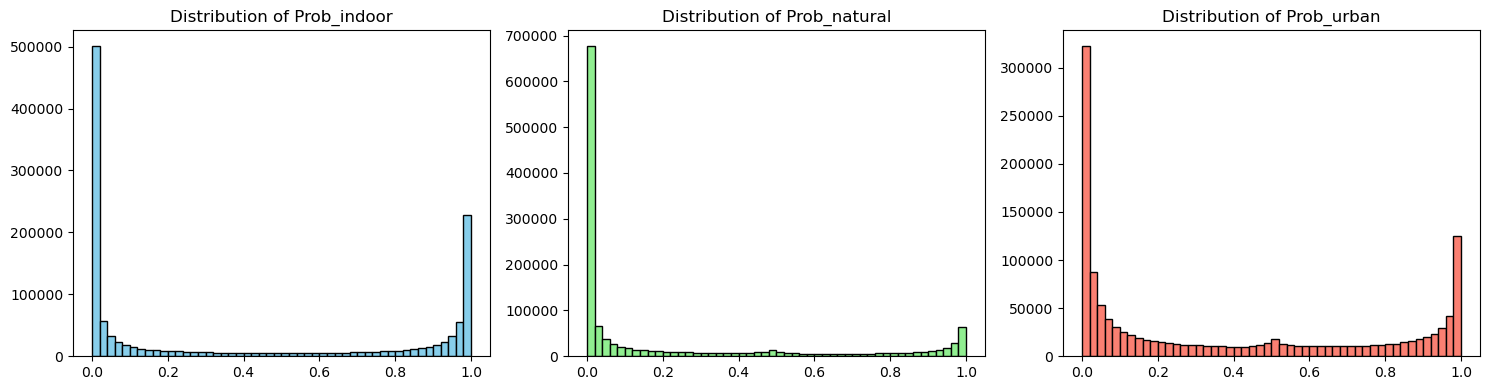

In [6]:
# Plot histograms for each feature probability
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(meta_within_CONUS['Prob_indoor'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title("Distribution of Prob_indoor")
axes[1].hist(meta_within_CONUS['Prob_natural'], bins=50, color='lightgreen', edgecolor='black')
axes[1].set_title("Distribution of Prob_natural")
axes[2].hist(meta_within_CONUS['Prob_urban'], bins=50, color='salmon', edgecolor='black')
axes[2].set_title("Distribution of Prob_urban")
plt.tight_layout()
plt.show()

In [9]:
# Compute average probability for each class
avg_prob_indoor = meta_within_CONUS['Prob_indoor'].mean()
avg_prob_natural = meta_within_CONUS['Prob_natural'].mean()
avg_prob_urban   = meta_within_CONUS['Prob_urban'].mean()

print(f"Average Prob_indoor: {avg_prob_indoor:.3f}")
print(f"Average Prob_natural: {avg_prob_natural:.3f}")
print(f"Average Prob_urban:   {avg_prob_urban:.3f}")

# Apply a threshold (for example, 0.5)
threshold = 0.5
meta_within_CONUS['is_indoor'] = meta_within_CONUS['Prob_indoor'] > threshold
meta_within_CONUS['is_natural'] = meta_within_CONUS['Prob_natural'] > threshold
meta_within_CONUS['is_urban']   = meta_within_CONUS['Prob_urban'] > threshold

# Compute the proportion of images that are classified as each type (above the threshold)
total_images = len(meta_within_CONUS)
prop_indoor = meta_within_CONUS['is_indoor'].sum() / total_images
prop_natural = meta_within_CONUS['is_natural'].sum() / total_images
prop_urban   = meta_within_CONUS['is_urban'].sum() / total_images

print("\nProportion of images above threshold:")
print(f"Indoor: {prop_indoor:.3f} ({meta_within_CONUS['is_indoor'].sum()} out of {total_images})")
print(f"Natural: {prop_natural:.3f} ({meta_within_CONUS['is_natural'].sum()} out of {total_images})")
print(f"Urban:   {prop_urban:.3f} ({meta_within_CONUS['is_urban'].sum()} out of {total_images})")

Average Prob_indoor: 0.395
Average Prob_natural: 0.223
Average Prob_urban:   0.382

Proportion of images above threshold:
Indoor: 0.396 (510092 out of 1289639)
Natural: 0.204 (263668 out of 1289639)
Urban:   0.375 (484220 out of 1289639)


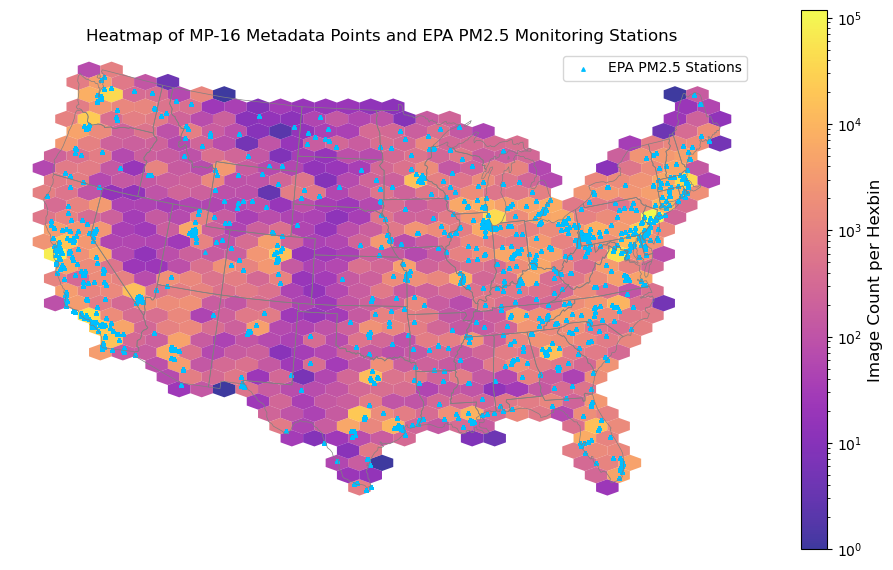

In [35]:
# -------------------------------------
# 2. Reproject Data to EPSG:5070
# -------------------------------------
meta_within_CONUS = meta_within_CONUS.to_crs(epsg=5070)
state_gdf_5070 = state_gdf.to_crs(epsg=5070)

# -------------------------------------
# 3. Reproject EPA PM2.5 Monitoring Stations
# -------------------------------------
epa_gdf = data_points.to_crs(epsg=5070)

# -------------------------------------
# 4. Create Visualization: Heatmap & Overlay EPA Stations
# -------------------------------------
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the CONUS state boundaries as background
state_gdf_5070.boundary.plot(ax=ax, linewidth=0.5, edgecolor='grey')

# Create a hexbin heatmap of MP-16 metadata points
# Adjust gridsize for resolution; here 100 is a starting point.
hb = ax.hexbin(
    meta_within_CONUS.geometry.x, meta_within_CONUS.geometry.y,
    gridsize=30,
    mincnt=1,
    cmap='plasma',
    alpha=0.8,
    edgecolors='none',
    norm=matplotlib.colors.LogNorm()
)
cb = plt.colorbar(hb, ax=ax, shrink=0.7)
cb.set_label('Image Count per Hexbin', fontsize=12)

# Overlay the EPA PM2.5 monitoring stations as blue circles
epa_gdf.plot(
    ax=ax,
    marker='^',
    color='deepskyblue',
    markersize=6,
    label='EPA PM2.5 Stations'
)

# Final plot adjustments: title, legend, and clean axis
ax.set_title("Heatmap of MP-16 Metadata Points and EPA PM2.5 Monitoring Stations")
ax.legend()
ax.set_axis_off()  # Optionally hide axes for a cleaner look

plt.savefig(f"../fig/MP16_EPA_distributions.png", dpi=300, bbox_inches="tight")

plt.show()